In [204]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
plt.style.use('seaborn-bright')

In [205]:
#Loading Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [206]:
print("Training data shape: {}".format(train.shape))
print("Testing data shape: {}".format(test.shape))

Training data shape: (8693, 14)
Testing data shape: (4277, 13)


In [207]:
#data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [208]:
#Statistics
train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [209]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [210]:
train = train.drop(columns=["Name"], axis=1) # drop name Column

In [211]:
test = test.drop(columns=["Name"], axis=1) # drop name Column

In [212]:
def create_features(df):
    df["Cabin"].fillna("Z/9999/Z", inplace=True)

    df["Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0]) # the Deck & Side 
    df["Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    del df["Cabin"]
    return df

In [213]:
train = create_features(train)
test = create_features(test)

In [214]:
train.shape

(8693, 14)

In [215]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,S


In [216]:
# Seperate categrocial and numerical values 
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
cat_features.remove('PassengerId')

In [217]:
cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

In [218]:
num_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [219]:
FEATURES = cat_features + num_features
FEATURES

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Deck',
 'Side',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [220]:
target = train['Transported']

In [221]:
target

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [222]:
train=train[FEATURES]

In [223]:
train

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,False,B,P,39.0,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,False,F,S,24.0,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,True,A,S,58.0,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,False,A,S,33.0,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,False,F,S,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,True,A,P,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,Earth,True,PSO J318.5-22,False,G,S,18.0,0.0,0.0,0.0,0.0,0.0
8690,Earth,False,TRAPPIST-1e,False,G,S,26.0,0.0,0.0,1872.0,1.0,0.0
8691,Europa,False,55 Cancri e,False,E,S,32.0,0.0,1049.0,0.0,353.0,3235.0


In [224]:
train.isna().sum()[train.isna().sum()>0]

HomePlanet      201
CryoSleep       217
Destination     182
VIP             203
Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [225]:
# Fill missing Values
from sklearn.impute import SimpleImputer

# Categorical
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

train[cat_features] = cat_imputer.fit_transform(train[cat_features])
test[cat_features] = cat_imputer.fit_transform(test[cat_features]) 

train[num_features] = num_imputer.fit_transform(train[num_features])
test[num_features] = num_imputer.fit_transform(test[num_features])

<ipython-input-225-101e121ea3fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_features] = cat_imputer.fit_transform(train[cat_features])
C:\Users\Noweto\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-225-101e121ea3fe>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [226]:
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [227]:
test.isna().sum()[test.isna().sum()>0]

Series([], dtype: int64)

In [228]:
train[num_features].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.341404,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


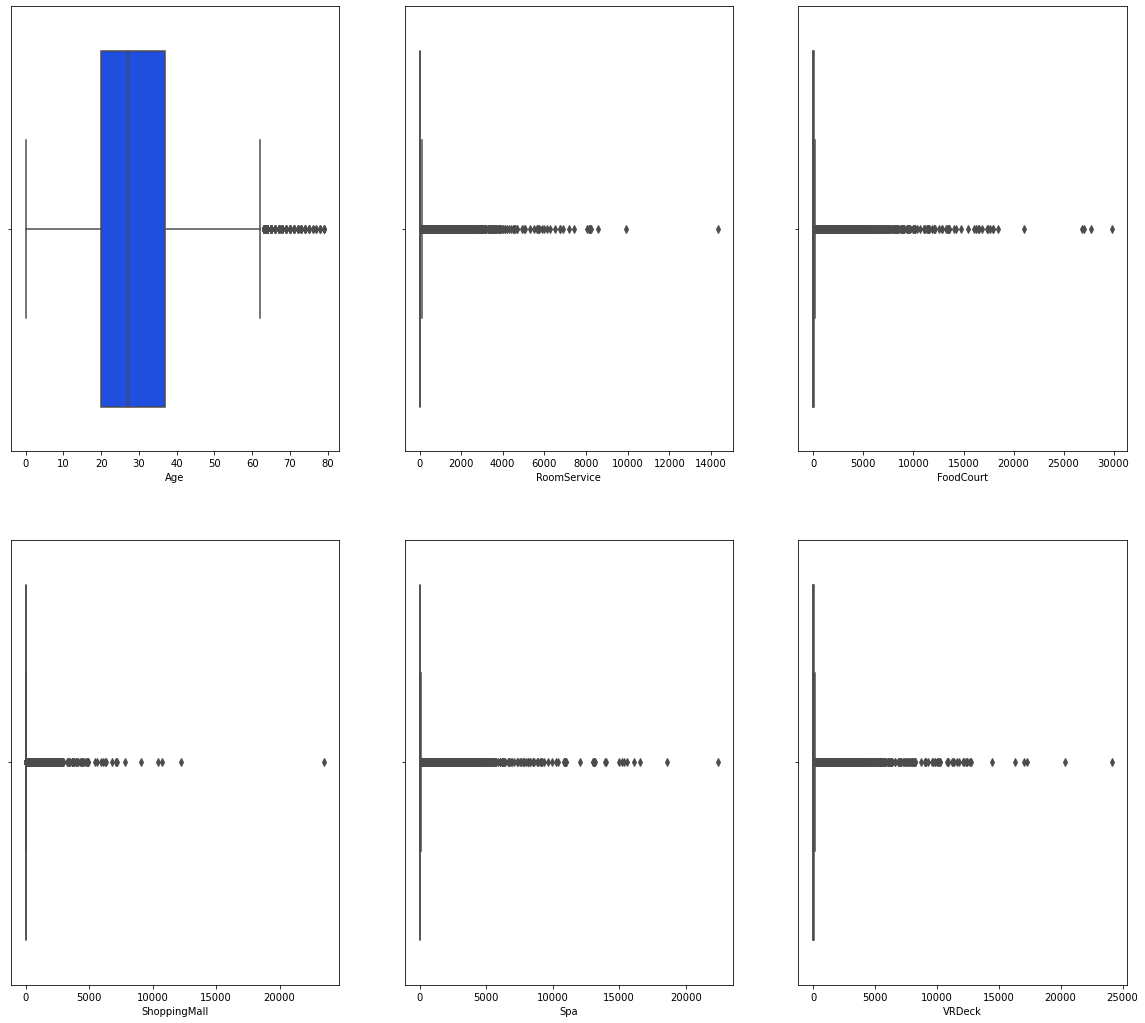

In [229]:
# Work in numerical columns 
import seaborn as sns
k=1
plt.figure(figsize=(20,18))
for col in num_features:
    plt.subplot(2,3,k) # 2*3 = 6 
    sns.boxplot(x=train[col])
    k+=1
plt.show()

In [230]:
# function to remove outliers

def remove_outlier(column):
    #1st Q
    p25 = column.describe()[4]
    #3rd Q
    p75 = column.describe()[6]
    IQR = p75 - p25
    ul = p75 + 1.5*IQR
    ll = p25 - 1.5*IQR
    column.mask(column>ul,ul,inplace=True) # apply mask to this outlayer .. enable you from control boundries
    column.mask(column<ll,ll,inplace=True)

In [231]:
for col in num_features:
    remove_outlier(train[col])

C:\Users\Noweto\anaconda3\lib\site-packages\pandas\core\generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\Noweto\anaconda3\lib\site-packages\pandas\core\generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\Noweto\anaconda3\lib\site-packages\pandas\core\generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\Noweto\anacon

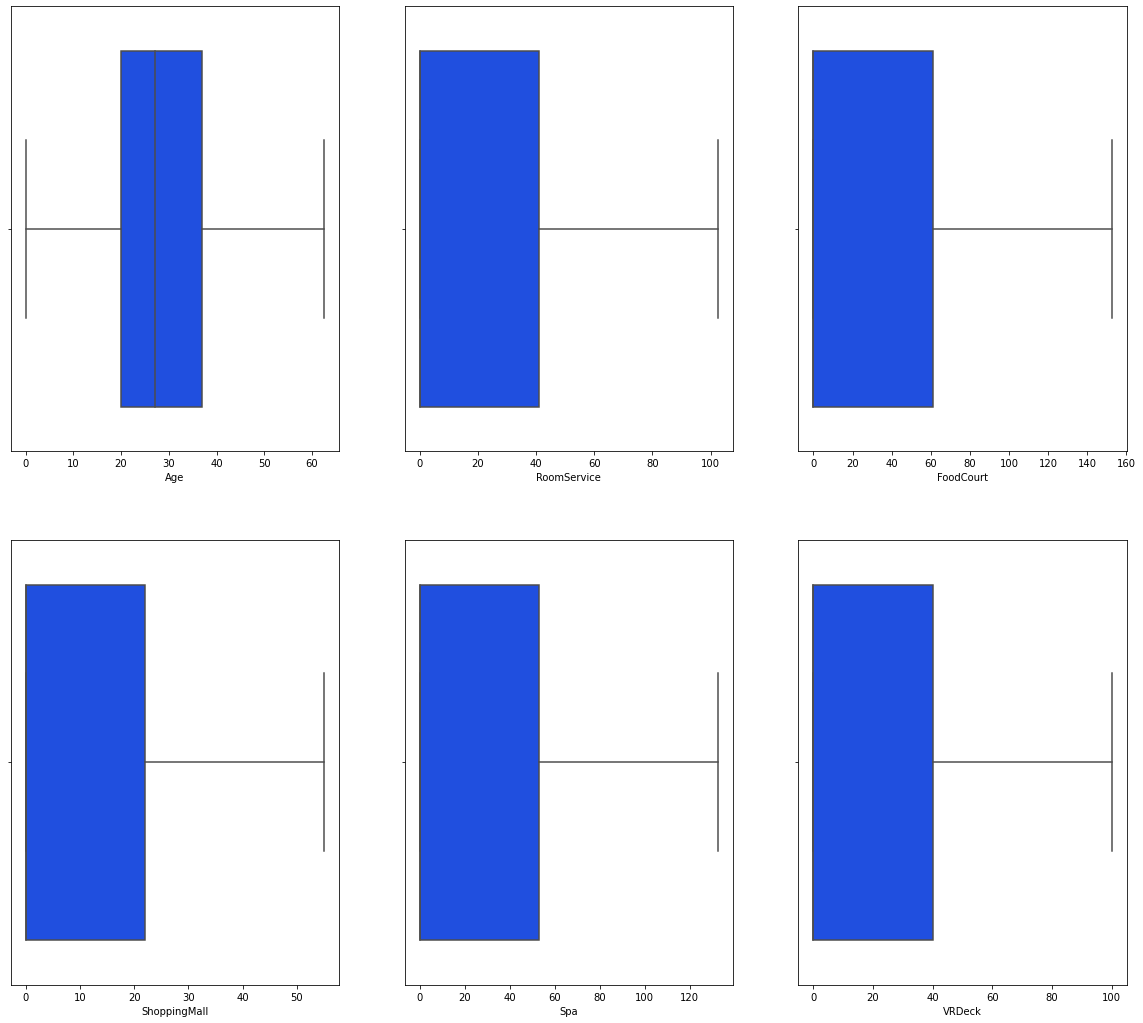

In [232]:
# Work in numerical columns 
import seaborn as sns
k=1
plt.figure(figsize=(20,18))
for col in num_features:
    plt.subplot(2,3,k) # 2*3 = 6 
    sns.boxplot(x=train[col])
    k+=1
plt.show()

In [233]:
# apply same process for test features 
for col in num_features:
    remove_outlier(test[col])

In [234]:
# apply standard scaling for numerical features
from sklearn.preprocessing import StandardScaler, LabelEncoder
train[num_features] = StandardScaler().fit_transform(train[num_features])
test[num_features] = StandardScaler().fit_transform(test[num_features])

<ipython-input-234-4944cacdcc09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_features] = StandardScaler().fit_transform(train[num_features])
C:\Users\Noweto\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [235]:
train[num_features]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.730929,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
1,-0.333351,1.801588,-0.460860,0.492290,1.819762,0.462971
2,2.079018,0.407572,1.797540,-0.601310,1.819762,0.583854
3,0.305217,-0.599868,1.797540,1.804611,1.819762,1.816853
4,-0.900968,1.801588,0.499156,1.804611,1.819762,-0.552441
...,...,...,...,...,...,...
8688,0.872833,-0.599868,1.797540,-0.601310,1.819762,1.188265
8689,-0.759064,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
8690,-0.191447,-0.599868,-0.602502,1.804611,-0.587952,-0.600793
8691,0.234265,-0.599868,1.797540,-0.601310,1.819762,1.816853


In [236]:
# Label Encoding For categrical features 

cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

In [237]:

for col in cat_features:
    train[col] = LabelEncoder().fit_transform(train[col])
    test[col] = LabelEncoder().fit_transform(test[col])    

<ipython-input-237-294a6a3e2d8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = LabelEncoder().fit_transform(train[col])


In [238]:
train

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1,0,2,0,1,0,0.730929,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
1,0,0,2,0,5,1,-0.333351,1.801588,-0.460860,0.492290,1.819762,0.462971
2,1,0,2,1,0,1,2.079018,0.407572,1.797540,-0.601310,1.819762,0.583854
3,1,0,2,0,0,1,0.305217,-0.599868,1.797540,1.804611,1.819762,1.816853
4,0,0,2,0,5,1,-0.900968,1.801588,0.499156,1.804611,1.819762,-0.552441
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,1,0,0,0.872833,-0.599868,1.797540,-0.601310,1.819762,1.188265
8689,0,1,1,0,6,1,-0.759064,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
8690,0,0,2,0,6,1,-0.191447,-0.599868,-0.602502,1.804611,-0.587952,-0.600793
8691,1,0,0,0,4,1,0.234265,-0.599868,1.797540,-0.601310,1.819762,1.816853


In [239]:
# Splitting the data
X = train
y = target

In [240]:
X

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1,0,2,0,1,0,0.730929,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
1,0,0,2,0,5,1,-0.333351,1.801588,-0.460860,0.492290,1.819762,0.462971
2,1,0,2,1,0,1,2.079018,0.407572,1.797540,-0.601310,1.819762,0.583854
3,1,0,2,0,0,1,0.305217,-0.599868,1.797540,1.804611,1.819762,1.816853
4,0,0,2,0,5,1,-0.900968,1.801588,0.499156,1.804611,1.819762,-0.552441
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,1,0,0,0.872833,-0.599868,1.797540,-0.601310,1.819762,1.188265
8689,0,1,1,0,6,1,-0.759064,-0.599868,-0.602502,-0.601310,-0.606261,-0.600793
8690,0,0,2,0,6,1,-0.191447,-0.599868,-0.602502,1.804611,-0.587952,-0.600793
8691,1,0,0,0,4,1,0.234265,-0.599868,1.797540,-0.601310,1.819762,1.816853


In [241]:
y

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [242]:
# SplittingData 
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2)

In [243]:
x_train.shape

(6954, 12)

In [244]:
y_train.shape

(6954,)

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
model = RandomForestRegressor(max_leaf_nodes = 125,random_state=1)
model.fit(x_train, y_train)



RandomForestRegressor(max_leaf_nodes=125, random_state=1)

In [246]:
from sklearn.metrics import mean_squared_log_error

mean_absolute_error(y_valid,model.predict(x_valid))**0.5



0.5449107357902259

In [247]:
Id = test['PassengerId']

In [248]:
Id.shape

(4277,)

In [249]:
test = test.drop(columns=['PassengerId'],axis=1)

In [250]:
test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
0,0,1,2,-0.109744,0,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259,6,1
1,0,0,2,-0.689982,0,-0.598524,-0.467635,-0.600724,1.807832,-0.598259,5,1
2,1,1,0,0.180375,0,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259,2,1
3,1,0,2,0.688082,0,-0.598524,1.802597,-0.600724,1.807832,1.808673,2,1
4,0,0,2,-0.617452,0,-0.397231,-0.598610,1.810736,-0.609523,-0.598259,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0.397964,0,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259,6,1
4273,0,0,2,0.978201,0,-0.598524,1.802597,0.006607,-0.384653,1.808673,8,2
4274,2,1,0,-0.182274,0,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259,3,0
4275,1,0,2,-0.182274,0,-0.598524,1.802597,-0.600724,-0.609523,1.808673,3,0


In [251]:
test = test[x_train.columns]

In [252]:
test

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,1,2,0,6,1,-0.109744,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259
1,0,0,2,0,5,1,-0.689982,-0.598524,-0.467635,-0.600724,1.807832,-0.598259
2,1,1,0,0,2,1,0.180375,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259
3,1,0,2,0,2,1,0.688082,-0.598524,1.802597,-0.600724,1.807832,1.808673
4,0,0,2,0,5,1,-0.617452,-0.397231,-0.598610,1.810736,-0.609523,-0.598259
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0,6,1,0.397964,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259
4273,0,0,2,0,8,2,0.978201,-0.598524,1.802597,0.006607,-0.384653,1.808673
4274,2,1,0,0,3,0,-0.182274,-0.598524,-0.598610,-0.600724,-0.609523,-0.598259
4275,1,0,2,0,3,0,-0.182274,-0.598524,1.802597,-0.600724,-0.609523,1.808673


In [253]:
predictions = model.predict(test)

In [254]:
predictions.shape


(4277,)

In [257]:
submission = pd.DataFrame({'PassengerId': Id.values,
                       'Transported': predictions})

In [258]:
submission.to_csv('submission.csv', index=False)

In [259]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

In [267]:
# Sequential API Neural network 
model = Sequential()

model.add(Dense(64, input_dim=x_train.shape[1], kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [268]:
model.compile(optimizer='adam', # optimization algorithm 
              loss='binary_crossentropy',
             metrics=['accuracy'])




In [269]:
history=model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=60, batch_size=10)

Epoch 1/60
696/696 [==============================] - 1s 1ms/step - loss: 0.6091 - accuracy: 0.6849 - val_loss: 0.5354 - val_accuracy: 0.7602
Epoch 2/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5537 - accuracy: 0.7627 - val_loss: 0.5210 - val_accuracy: 0.7637
Epoch 3/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5501 - accuracy: 0.7665 - val_loss: 0.5190 - val_accuracy: 0.7671
Epoch 4/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5433 - accuracy: 0.7650 - val_loss: 0.5159 - val_accuracy: 0.7619
Epoch 5/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5394 - accuracy: 0.7670 - val_loss: 0.5228 - val_accuracy: 0.7619
Epoch 6/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5351 - accuracy: 0.7670 - val_loss: 0.5208 - val_accuracy: 0.7642
Epoch 7/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5363 - accuracy: 0.7643 - val_loss: 0.5164 - val_accuracy: 0.7637
Epoch 

696/696 [==============================] - 1s 1ms/step - loss: 0.5280 - accuracy: 0.7596 - val_loss: 0.5097 - val_accuracy: 0.7665
Epoch 59/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5330 - accuracy: 0.7609 - val_loss: 0.5113 - val_accuracy: 0.7688
Epoch 60/60
696/696 [==============================] - 1s 1ms/step - loss: 0.5274 - accuracy: 0.7600 - val_loss: 0.5097 - val_accuracy: 0.7700


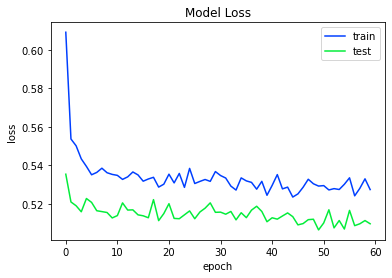

In [270]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [271]:
mean_absolute_error(y_valid,model.predict(x_valid))**0.5


0.5657348599888152

In [276]:
predictions = model.predict(test)

In [280]:
len(predictions)

4277

In [281]:
predictions = predictions.reshape((4277,))

In [282]:
submission = pd.DataFrame({'PassengerId': Id.values,
                       'Transported': predictions})

In [283]:
submission.to_csv('submission.csv', index=False)